# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [6]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

cuda


In [2]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [4]:
def get_sd_scan_cluster_num_and_bead_lst(param_dir_path):   
    seed_paths = [path for path in param_dir_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    sd_cluster_num_lst = []
    sd_total_bead_lst = []
    
    for sp in seed_paths:
        time_arr, com_arr, t_grp_clusters = cla.collect_cluster_data(sp)
        trees = cla.make_cluster_trees(t_grp_clusters)
        num_cluster_arr = np.zeros(time_arr.shape)
        num_cluster_beads_arr = np.zeros(time_arr.shape)
        for tree in trees:
            for clust in tree.clusters:
                t_idx = np.where(time_arr == clust.time)
                num_cluster_arr[t_idx] += 1
                num_cluster_beads_arr[t_idx] += len(clust.part_ids)
            
        sd_cluster_num_lst += [num_cluster_arr]
        sd_total_bead_lst += [num_cluster_beads_arr]
    # TODO Pad this array with empty values
    return time_arr, sd_cluster_num_lst, sd_total_bead_lst

In [5]:
def poly_bead_rmsd(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0)
    rmsd = torch.zeros(Ttot, device=device)
    for i in range(1,Ttot):
        tdiff_mat = (tcom_arr[:,:,i:] - pol_com[:,i:]) - (tcom_arr[:,:,:-i] - pol_com[:,:-i])
        rmsd[i] = torch.einsum('ijk,ijk->', tdiff_mat, tdiff_mat)/((Ttot-i)*n)
        
    return rmsd


In [6]:
def poly_autocorr(com_arr):
    avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0).to(device)
    autocorr = torch.zeros(Ttot, device=device)
    for i in range(1,Ttot):
        autocorr[i] = ((tcom_arr[:,:,i:] - pol_com[:,i:])* 
                                (tcom_arr[:,:,:-i] - pol_com[:,:-i])).sum()/((Ttot-i)*(avg_rog*avg_rog)*n)
        
    return autocorr


In [7]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def poly_autocorr_fast(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    n = next_pow_two(nsteps)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_arr-pol_com, dim=[-1], norm='forward')
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)
        


In [8]:
def sep_autocorr(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    n = tsep_mat.shape[0]
    Ttot = tsep_mat.shape[-1]
    tcorr_d = torch.zeros(tsep_mat.shape[-1], device=device)
    avg_tsep_mat = tsep_mat.mean(dim=(0,1)).to(device)
    avg_sep = avg_tsep_mat.mean()
    for i in range(1,tsep_mat.shape[-1]):
        tcorr_d[i] = ((tsep_mat[:,:,i:] - avg_tsep_mat[i:]) * (tsep_mat[:,:,:-i]-avg_tsep_mat[:-i])).sum()/(n*n*avg_sep*avg_sep*(Ttot-i))
        
    return tcorr_d


In [9]:

def autocorr_fast(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    t0 = time.time()
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    t1 = time.time()
    print(f'tsep_mat = {t1-t0}')
    nsteps = tsep_mat.shape[-1]
    n = next_pow_two(nsteps)
    t2 = time.time()
    print(f'power of two = {t2-t1}')

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tsep_mat, s=[2 * n], dim=[-1])
    t3 = time.time()
    print(f'fft = {t3-t2}')
    autocorr = torch.fft.ifftn(torch.einsum('ijk,ijk->ik', f,
                                       torch.conjugate(f)),
                             dim=[-1])[:nsteps].real
    t4 = time.time()
    print(f'ifft = {t4-t3}')

    autocorr /= 4 * n
    return autocorr


In [10]:
def monoExp(x, m, a):
    return m * np.exp(-a * x)

def negmonoExp(x, m, a):
    return m*(1. - np.exp(-a * x))

def line_func(x, a, b):
    return a*x + b

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM
def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def func_powerlaw_zero(x, a, b, c):
    return b * np.power(x,c)

def rsqr_val(func, x, y, popts):
    residuals = y - func(x, *popts)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1. - (ss_res / ss_tot)

# Single seeds

In [8]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod300/s1")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = next(data_path.glob('analysis/cluster*.h5')) 
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

root_clusters = cla.find_descendants(clusters, thresh=.1, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

# for tree in trees:
for tree in filter(lambda x: len(x.clusters) > 20, trees):
    tree.prune_branches()

    

(2401,)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


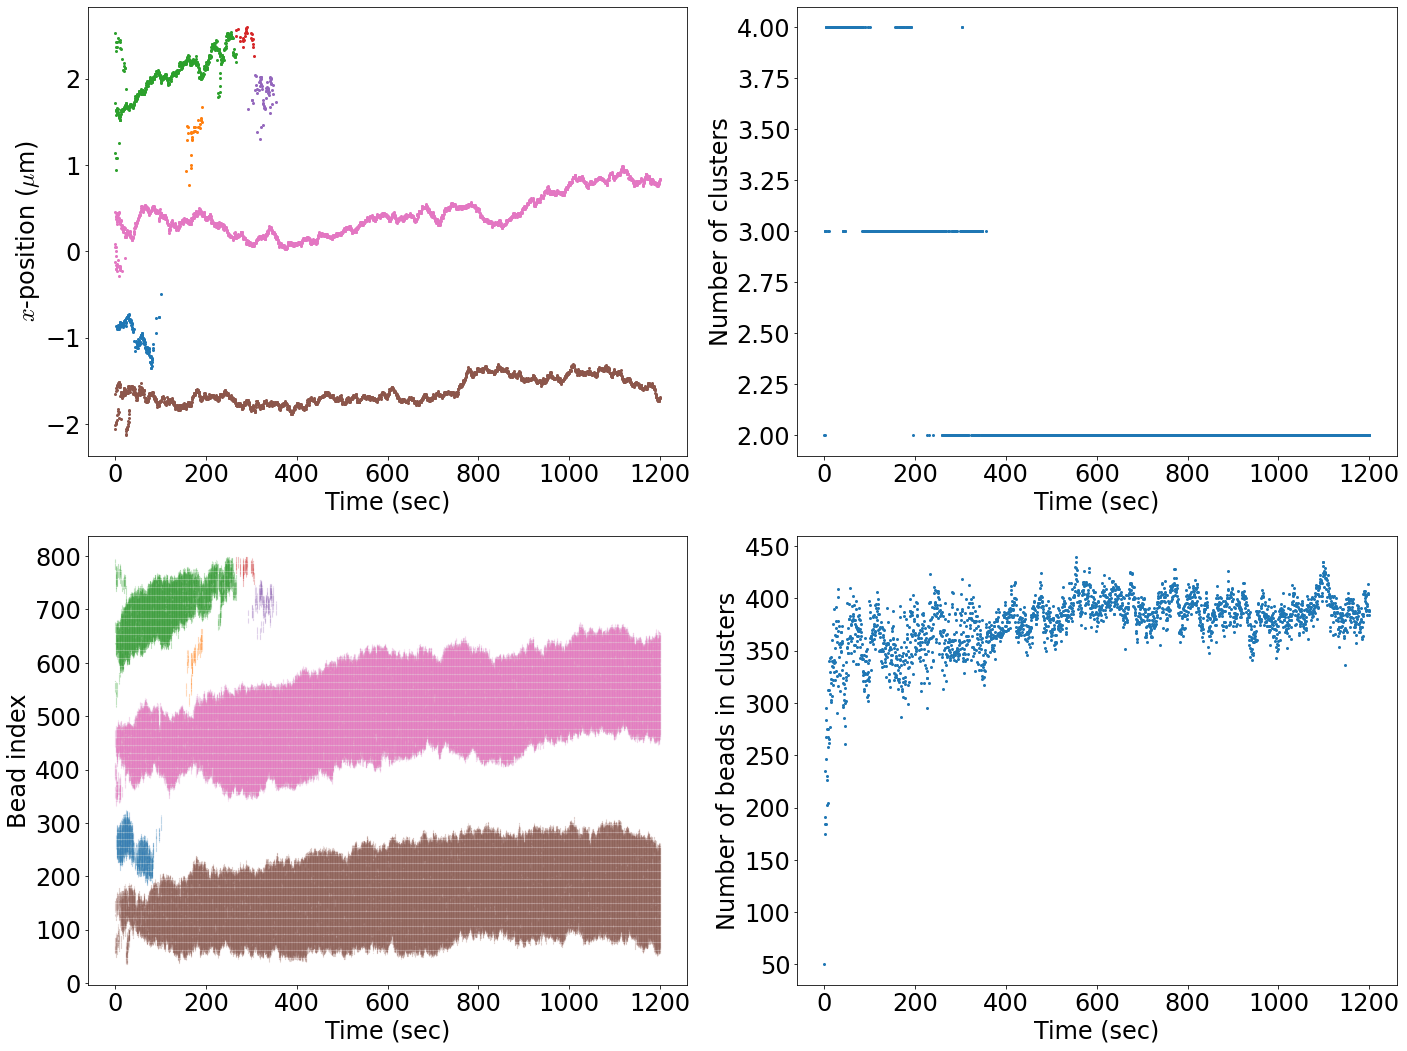

In [9]:
num_cluster_arr = np.zeros(time_arr.shape)
num_cluster_beads_arr = np.zeros(time_arr.shape)

fig, axarr = plt.subplots(2,2, figsize=(20, 15))
for tree in trees:
    if len(tree.clusters) < 20:
        continue
    time_lst = []
    flat_time_lst = []
    clust_ids = []
    clust_centers = []
    for clust in tree.clusters:

        t_idx = np.where(time_arr == clust.time)
        if clust.time not in time_lst:
            num_cluster_arr[t_idx] += 1
        num_cluster_beads_arr[t_idx] += len(clust.part_ids)

        time_lst += [clust.time]
        clust_centers += [clust.center]

        flat_time_lst += [clust.time]*len(clust.part_ids)
        clust_ids += clust.part_ids.tolist()
    _ = axarr[0,0].scatter(time_lst, np.array(clust_centers)[:,0])
    _ = axarr[1,0].scatter(flat_time_lst, clust_ids, s= .01, marker='.')

_ = axarr[0,1].scatter(time_arr, num_cluster_arr)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_arr)

_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

In [10]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod300/s2")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = next(data_path.glob('analysis/cluster*.h5')) 
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

root_clusters = cla.find_descendants(clusters, thresh=.25, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

# for tree in trees:
for tree in filter(lambda x: len(x.clusters) > 20, trees):
    tree.prune_branches()

    

(2401,)


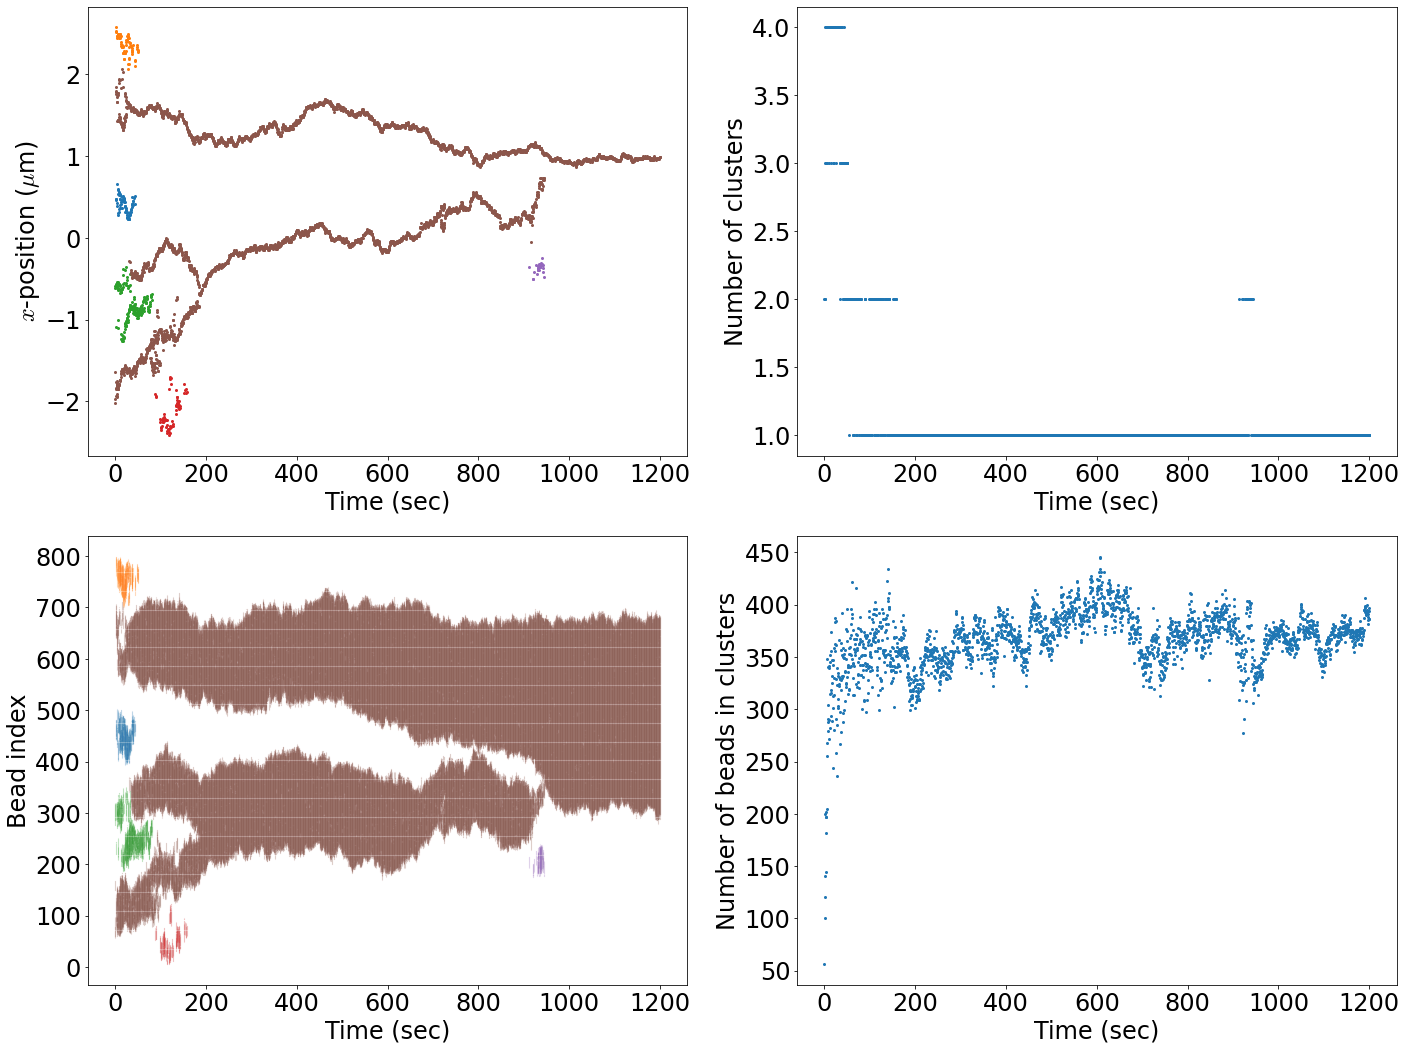

In [11]:
num_cluster_arr = np.zeros(time_arr.shape)
num_cluster_beads_arr = np.zeros(time_arr.shape)

fig, axarr = plt.subplots(2,2, figsize=(20, 15))
for tree in trees:
    if len(tree.clusters) < 20:
        continue
    time_lst = []
    flat_time_lst = []
    clust_ids = []
    clust_centers = []
    for clust in tree.clusters:

        t_idx = np.where(time_arr == clust.time)
        if clust.time not in time_lst:
            num_cluster_arr[t_idx] += 1
        num_cluster_beads_arr[t_idx] += len(clust.part_ids)

        time_lst += [clust.time]
        clust_centers += [clust.center]

        flat_time_lst += [clust.time]*len(clust.part_ids)
        clust_ids += clust.part_ids.tolist()
    _ = axarr[0,0].scatter(time_lst, np.array(clust_centers)[:,0])
    _ = axarr[1,0].scatter(flat_time_lst, clust_ids, s= .01, marker='.')

_ = axarr[0,1].scatter(time_arr, num_cluster_arr)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_arr)

_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

In [12]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod0.1/s2")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = next(data_path.glob('analysis/cluster*.h5')) 
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

root_clusters = cla.find_descendants(clusters, thresh=.10, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

# for tree in trees:
for tree in filter(lambda x: len(x.clusters) > 20, trees):
    tree.prune_branches()

    

(2401,)


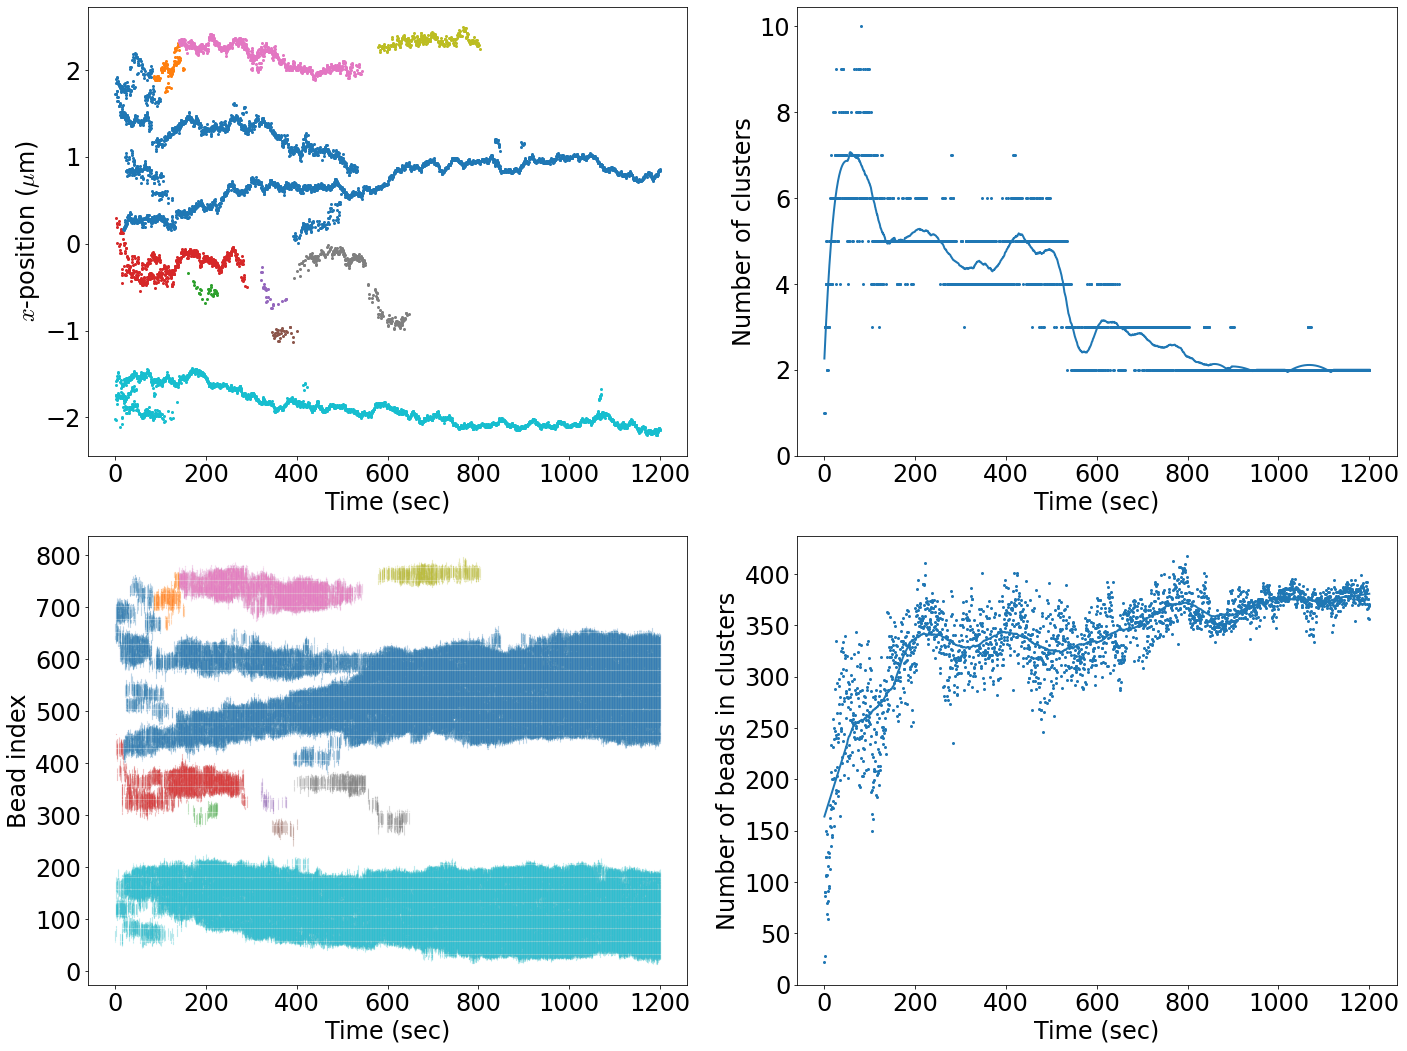

In [13]:
num_cluster_arr = np.zeros(time_arr.shape)
num_cluster_beads_arr = np.zeros(time_arr.shape)

fig, axarr = plt.subplots(2,2, figsize=(20, 15))
for tree in trees:
    if len(tree.clusters) < 20:
        continue
    time_lst = []
    flat_time_lst = []
    clust_ids = []
    clust_centers = []
    for clust in tree.clusters:

        t_idx = np.where(time_arr == clust.time)
        # if clust.time not in time_lst:
        num_cluster_arr[t_idx] += 1
        num_cluster_beads_arr[t_idx] += len(clust.part_ids)

        time_lst += [clust.time]
        clust_centers += [clust.center]

        flat_time_lst += [clust.time]*len(clust.part_ids)
        clust_ids += clust.part_ids.tolist()
    _ = axarr[0,0].scatter(time_lst, np.array(clust_centers)[:,0])
    _ = axarr[1,0].scatter(flat_time_lst, clust_ids, s= .01, marker='.')

_ = axarr[0,1].scatter(time_arr, num_cluster_arr)
_ = axarr[0,1].plot(time_arr, savgol_filter(num_cluster_arr, 201, 3))
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_arr)
_ = axarr[1,1].plot(time_arr, savgol_filter(num_cluster_beads_arr, 201, 1))
_ = axarr[0, 1].set_ylim(0)
_ = axarr[1, 1].set_ylim(0)

_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

# Seed scan

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


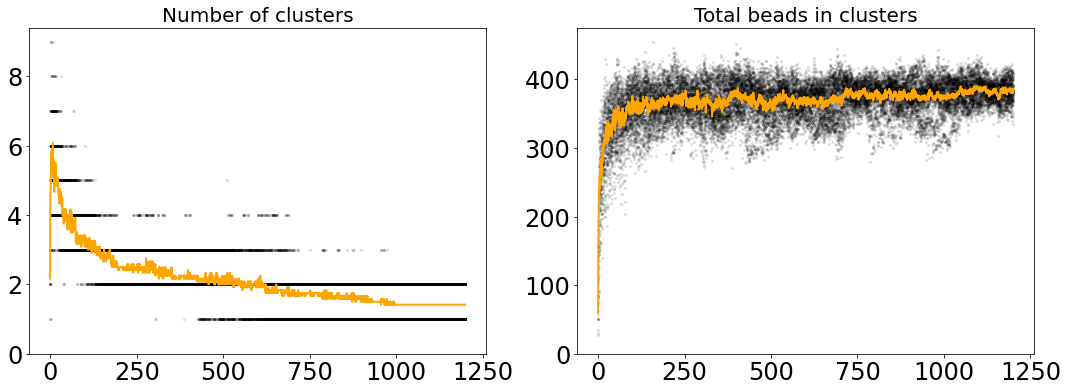

In [14]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod100")
fig, axarr = plt.subplots(1,2, figsize=(18,6))
num_seeds = 0.
h5_data_lst = []
try:
    time_arr, avg_cluster_num, avg_total_bead  = get_sd_scan_cluster_num_and_bead_lst(data_path)
    for num_cluster_arr, num_cluster_beads_arr in zip(avg_cluster_num, avg_total_bead):
        _ = axarr[0].scatter(time_arr, num_cluster_arr, color='k',alpha=.1)
        # _ = axarr[2].plot(time_arr, savgol_filter(num_cluster_beads_arr, 201, 3), color='k',alpha=.1)
        _ = axarr[1].scatter(time_arr, num_cluster_beads_arr, color='k',alpha=.1)
    
        
    _ = axarr[0].plot(time_arr, np.array(avg_cluster_num).mean(axis=0), color='orange')
    _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    _ = axarr[0].set_title('Number of clusters')
    _ = axarr[1].set_title('Total beads in clusters')

    _ = axarr[0].set_ylim(0)
    _ = axarr[1].set_ylim(0)
        
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

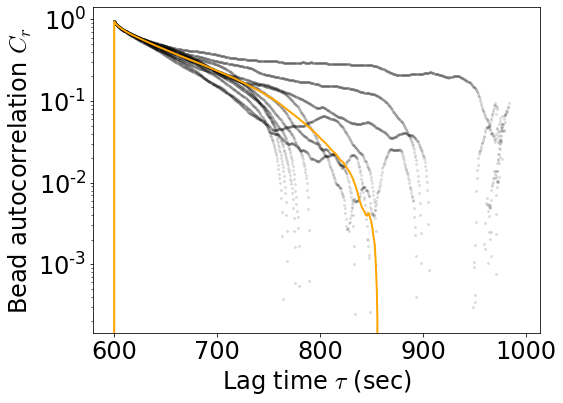

In [35]:
data_path = (ceph_path /"22_aLc800_sticky_runs/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = None
start_bead = 0
end_bead = None

auto_corr_list = []
try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            time_arr = h5_data['time'][ss_ind:end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

            auto_corr_list += [poly_autocorr(com_arr)]
            _ = axarr.scatter(time_arr, auto_corr_list[-1], color='k',alpha=.1)

    min_length = min([len(avg) for avg in auto_corr_list])
    auto_corr_list = np.array([avg[:min_length] for avg in auto_corr_list])
    
        
    _ = axarr.plot(time_arr[:min_length], np.array(auto_corr_list).mean(axis=0), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
    # _ = axarr.set_yscale('log')
    # _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    # _ = axarr[0].set_title('Number of clusters')
    # _ = axarr[1].set_title('Total beads in clusters')

    # _ = axarr[0].set_ylim(0)
    # _ = axarr[1].set_ylim(0)
        
except:
    raise

In [5]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    tcorr_d_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            tcom_arr = torch.from_numpy(com_arr).to(device)
            tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2)
            n = tsep_mat.shape[0]
            Ttot = tsep_mat.shape[-1]
            tcorr_d = torch.zeros(tsep_mat.shape[-1], device=device)
            avg_tsep_mat = tsep_mat.mean(dim=(0,1))
            avg_sep = avg_tsep_mat.mean()
            for i in tqdm(range(1,tsep_mat.shape[-1])):
                    tcorr_d[i] = ((tsep_mat[:,:,i:] - avg_tsep_mat[i:]) * (tsep_mat[:,:,:-i]-avg_tsep_mat[:-i])).sum()/(n*n*avg_sep*avg_sep*(Ttot-i))
            tcorr_d_list += [tcorr_d]

            _ = axarr.scatter(lag_arr, tcorr_d_list[-1].cpu(), color='k',alpha=.1)

    min_length = min([arr.shape[-1] for arr in tcorr_d_list])
    tcorr_d_avg = torch.stack([arr[:min_length] for arr in tcorr_d_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], tcorr_d_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
        
except:
    raise

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/766 [00:00<?, ?it/s]

  0%|          | 0/769 [00:00<?, ?it/s]

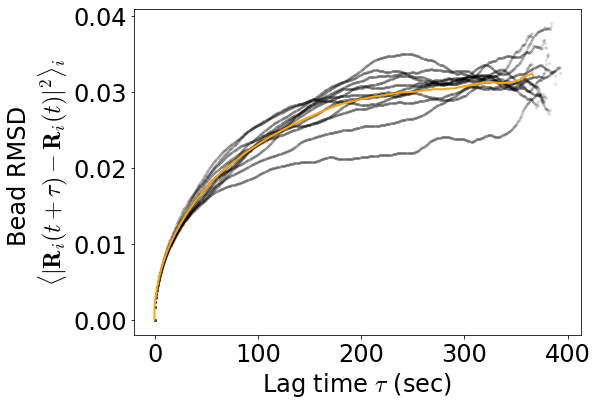

In [34]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    rmsd_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rmsd_list += [poly_bead_rmsd(com_arr)]

            _ = axarr.scatter(lag_arr, rmsd_list[-1].cpu(), color='k',alpha=.1)

    min_length = min([arr.shape[-1] for arr in rmsd_list])
    rmsd_avg = torch.stack([arr[:min_length] for arr in rmsd_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], rmsd_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


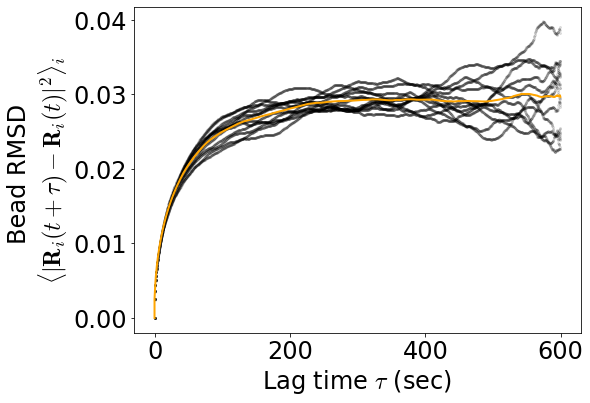

In [8]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    rmsd_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rmsd_list += [poly_bead_rmsd(com_arr)]

            _ = axarr.scatter(lag_arr, rmsd_list[-1].cpu(), color='k',alpha=.1)

    min_length = min([arr.shape[-1] for arr in rmsd_list])
    rmsd_avg = torch.stack([arr[:min_length] for arr in rmsd_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], rmsd_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

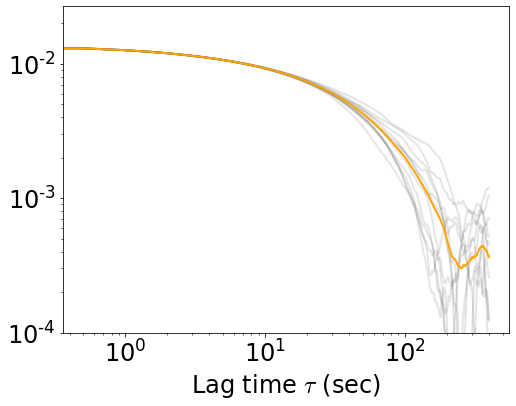

In [28]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = -1600
end_ind = -1
start_bead = 0
end_bead = None


try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    corr_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            corr_list  += [poly_autocorr_fast(com_arr)[:valid_n]]
            # fft = torch.fft.fft(com_arr, dim=-1)
            # power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            # n_beads = com_arr.shape[0]
            # corr_list  += [torch.fft.ifft(power_spec,dim=-1).mean(dim=0)]

            # corr_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            # freq = torch.fft.fftfreq(corr_list[-1].size(dim=0), lag_arr[2]-lag_arr[1])
            # freqs = torch.fft.fftshift(freq)
            # _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)
            # corr_list  += [power_spec.mean(dim=0)]

            # power_spec = [torch.fft.fftshift(power_spec.mean(axis=0))]
            # freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            # freqs = torch.fft.fftshift(freq)
            _ = axarr.plot(lag_arr, corr_list[-1].cpu(), color='k', alpha=.1)
            # rmsd_list += [poly_bead_rmsd(com_arr)]


    min_length = min([arr.shape[-1] for arr in corr_list])
    corr_avg = torch.stack([arr[:min_length] for arr in corr_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], corr_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_yscale('log')
    _ = axarr.set_ylim(.0001)
    _ = axarr.set_xscale('log')
    # _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

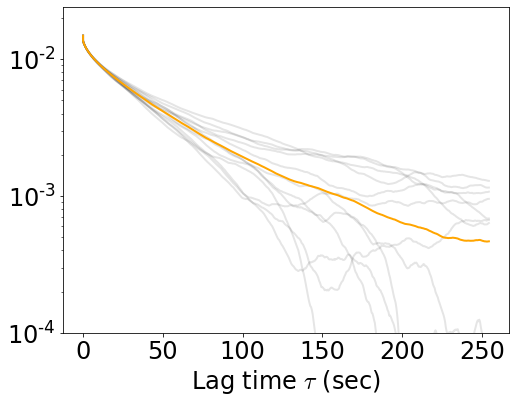

In [15]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None


try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    corr_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            corr_list  += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr.plot(lag_arr, corr_list[-1].cpu(), color='k', alpha=.1)


    min_length = min([arr.shape[-1] for arr in corr_list])
    corr_avg = torch.stack([arr[:min_length] for arr in corr_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], corr_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_yscale('log')
    _ = axarr.set_ylim(.0001)
    # _ = axarr.set_xscale('log')
    # _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

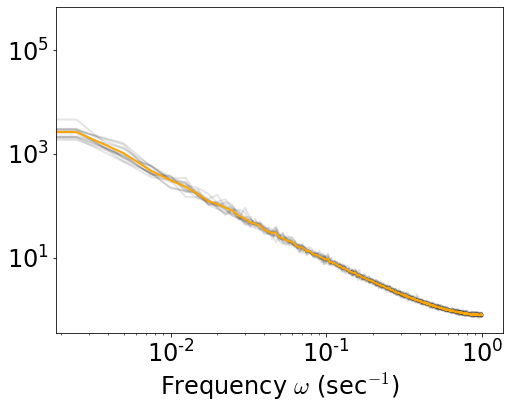

In [50]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None


try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    corr_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = torch.from_numpy(.5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :]))
            fft = torch.fft.fft(com_arr, dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]
            # corr_list  += [torch.fft.ifft(power_spec,dim=-1).mean(dim=0)]

            corr_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            # freq = torch.fft.fftfreq(corr_list[-1].size(dim=0), lag_arr[2]-lag_arr[1])
            # freqs = torch.fft.fftshift(freq)
            # _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)
            # corr_list  += [power_spec.mean(dim=0)]

            # power_spec = [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec.size(dim=1), lag_arr[2]-lag_arr[1])
            freqs = torch.fft.fftshift(freq)
            _ = axarr.plot(freqs, corr_list[-1].cpu(), color='k', alpha=.1)
            # rmsd_list += [poly_bead_rmsd(com_arr)]


    min_length = min([arr.shape[-1] for arr in corr_list])
    corr_avg = torch.stack([arr[:min_length] for arr in corr_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(freqs[:min_length], corr_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    # _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

[0.72402419 0.01522212]


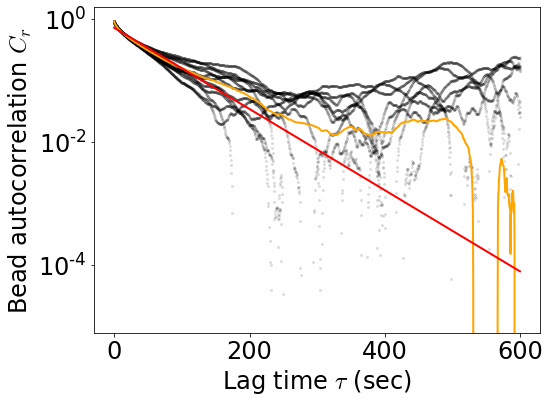

In [57]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

auto_corr_list = []
try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            com_arr -= com_arr.mean(axis=0)

            auto_corr_list += [poly_autocorr(com_arr)]
            _ = axarr.scatter(lag_arr, auto_corr_list[-1], color='k',alpha=.1)

    min_length = min([len(avg) for avg in auto_corr_list])
    auto_corr_list = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
    _ = axarr.plot(lag_arr[1:min_length], auto_corr_list.mean(axis=0)[1:], color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
    _ = axarr.set_yscale('log')
    params, cv = curve_fit(monoExp, lag_arr[1:min_length], auto_corr_list.mean(axis=0)[1:])
    _ = axarr.plot(lag_arr[1:min_length], monoExp(lag_arr[1:min_length], *params), color='r')
    print(params)
    # _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    # _ = axarr[0].set_title('Number of clusters')
    # _ = axarr[1].set_title('Total beads in clusters')

    # _ = axarr[0].set_ylim(0)
    # _ = axarr[1].set_ylim(0)
        
except:
    raise

# Param-seed scan

## Pinned scans

In [8]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf")

param_paths = [path for path in data_path.glob('simulations/kod*/') if path.is_dir()]
for pp in param_paths:
    anal_path = data_path /f'analysis/{pp.name}'
    _ = anal_path.mkdir(exist_ok=True)
    with h5py.File(anal_path / f'{pp.name}_sd_scan.h5', 'w') as h5_data:
        time_arr, seed_cluster_num, seed_total_bead  = get_sd_scan_cluster_num_and_bead_lst(pp)
        _ = h5_data.create_dataset('time', data=time_arr)
        _ = h5_data.create_dataset('sd_cluster_num', data=seed_cluster_num)
        _ = h5_data.create_dataset('sd_total_cluster_bead_num', data=seed_total_bead)





kod1
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod1
kod0.1
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod0.1
kod100
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod100
kod3
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod3
kod30
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod30
kod300
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod300
kod0.3
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod0.3
kod10
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod10


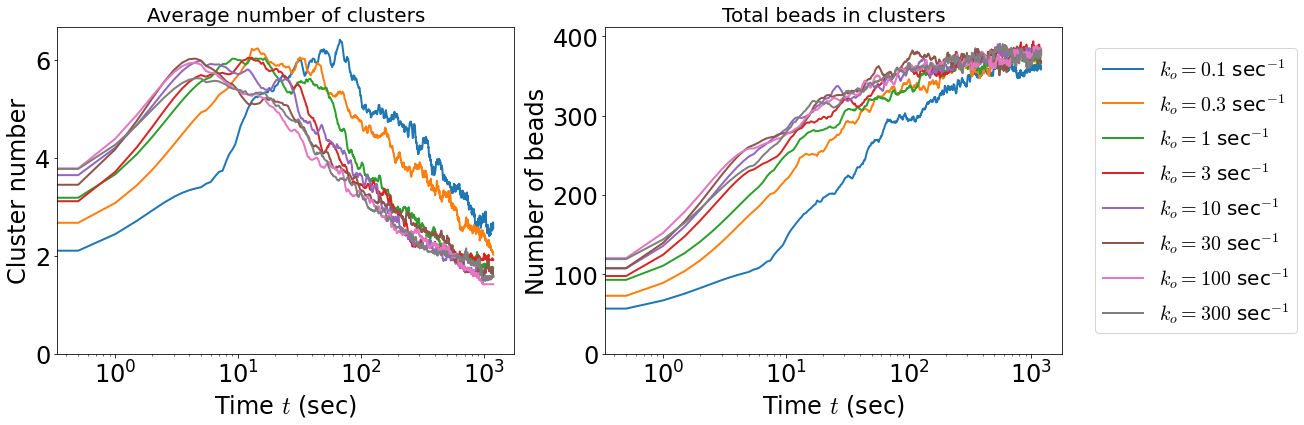

In [ ]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/analysis")
fig, axarr = plt.subplots(1,2, figsize=(18,6))
mp = re.compile('kod(\d*\.?\d+)')

param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
for pdir in param_dirs:
    with h5py.File(next(pdir.glob('*sd_scan.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
        sd_cluster_num = h5_data['sd_cluster_num'][...]
        sd_total_cluster_bead_num = h5_data['sd_total_cluster_bead_num'][...]
        label = re.split(r'(^[^\d]+)',str(pdir.name))[1:][1]
    
    
        
    _ = axarr[0].plot(time_arr, savgol_filter(np.array(sd_cluster_num).mean(axis=0), 21, 3))
    # _ = axarr[1].plot(time_arr, np.array(sd_total_cluster_bead_num).mean(axis=0), label=f"$k_o = {label}$ sec$^{{-1}}$")
    _ = axarr[1].plot(time_arr, savgol_filter(np.array(sd_total_cluster_bead_num).mean(axis=0), 21, 3), label=f"$k_o = {label}$ sec$^{{-1}}$")

_ = axarr[0].set_title('Average number of clusters')
_ = axarr[1].set_title('Total beads in clusters')

_ = axarr[0].set_ylabel('Cluster number')
_ = axarr[1].set_ylabel('Number of beads')


for ax in axarr:
    _ = ax.set_xscale('log')
    _ = ax.set_ylim(0)
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


## $K_e$ scans

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


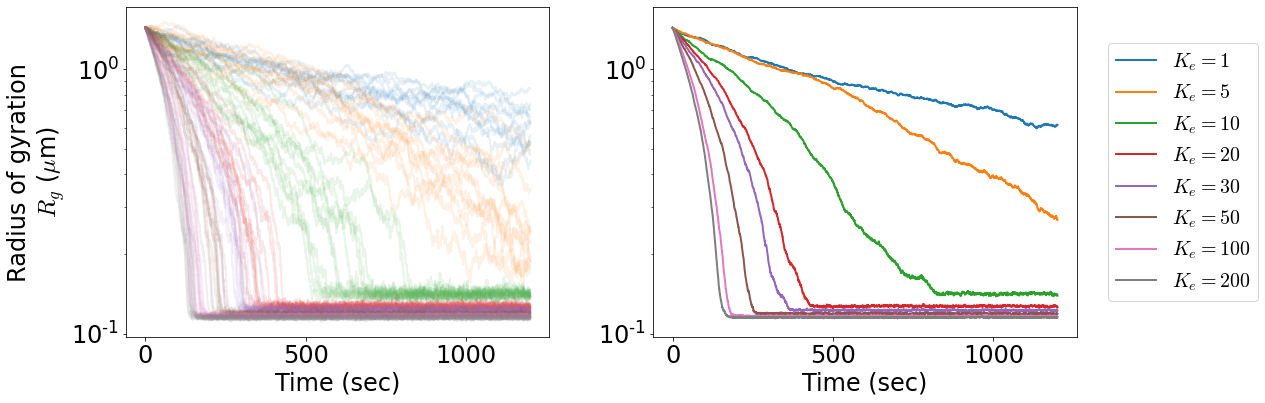

In [ ]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

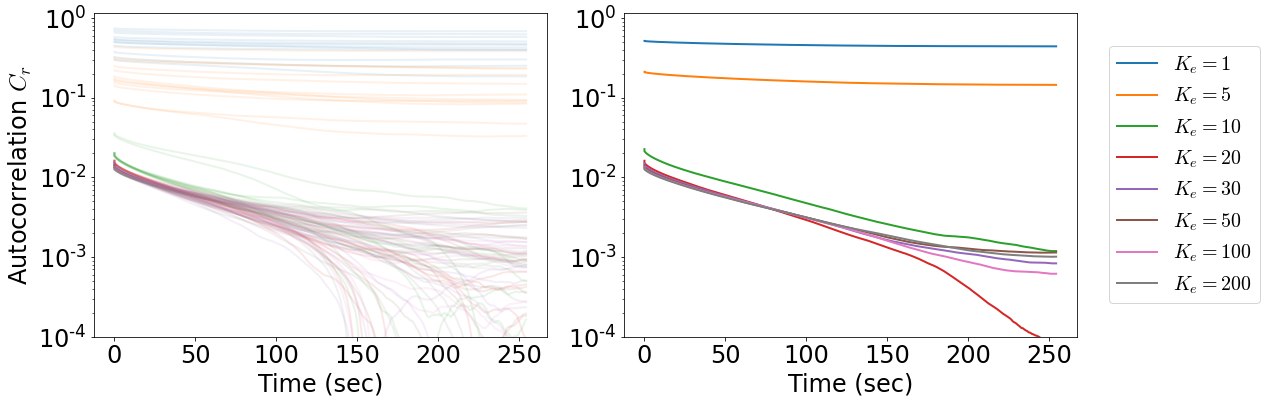

In [13]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i],label=f"$K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

In [14]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r' $C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):
            t0 = time.time()
            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            t1 = time.time()
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            print(f'com load time = {t1-t0}')
            n_beads = com_arr.shape[0]
            auto_corr_list += [autocorr_fast(com_arr)]
            t2 = time.time()
            print(f'autocorr time = {t2-t1}')
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r' $C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

com load time = 0.02950906753540039


0it [00:00, ?it/s]

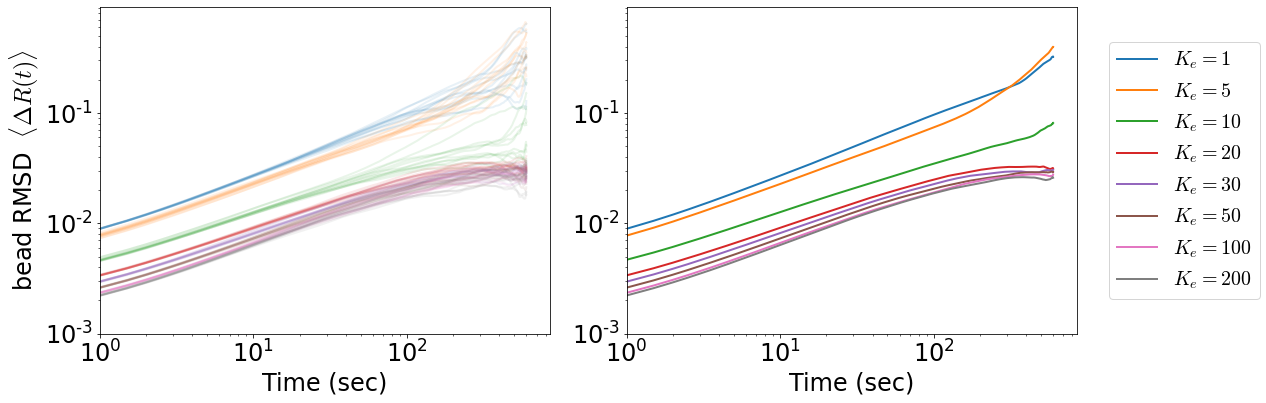

In [12]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('bead RMSD ' + r' $\langle \Delta R(t)\rangle$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.001)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## $k_o$ scans

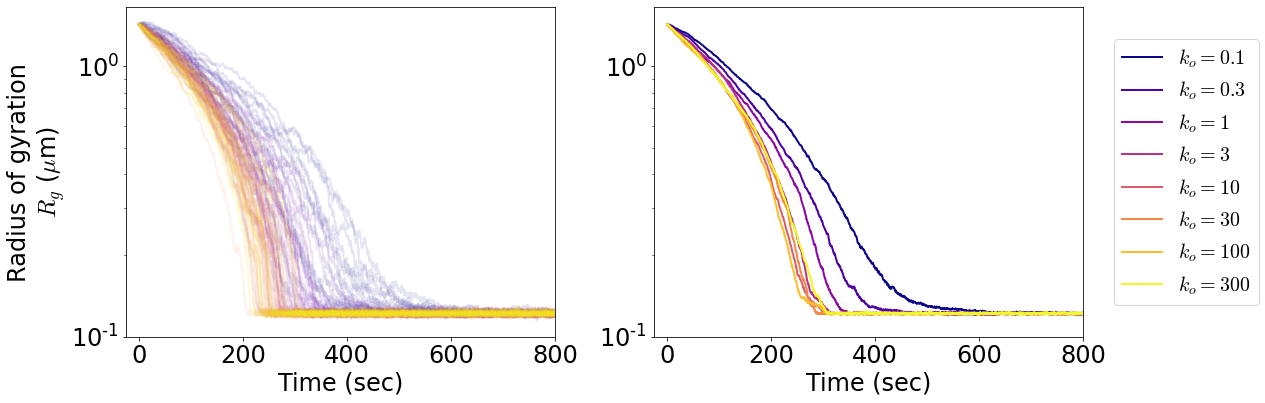

In [9]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
# colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)
    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(.1)
    _ = axarr1[0].set_xlim(-25, 800)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

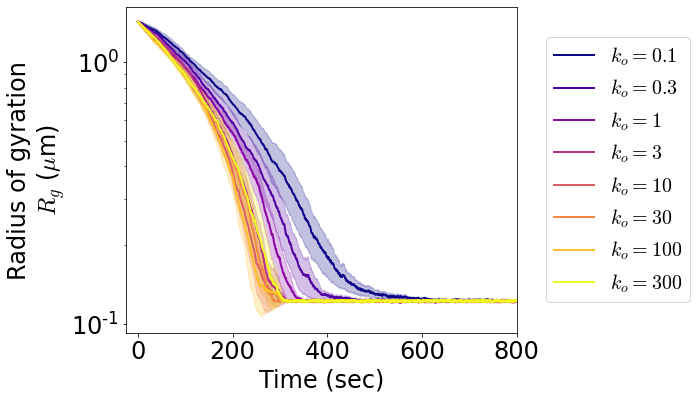

In [12]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = 1
# end_ind = -1600
end_ind = -1
start_bead = 0
end_bead = None

mp = re.compile('kod(\d*\.?\d+)')

try:
    fig1, axarr1 = plt.subplots(figsize=(7, 6))

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            rog = aa.calc_rad_of_gyration(com_arr)
            avg_ee_arrs += [rog.tolist()]
            # _ = axarr1.plot(time_arr, rog, color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$k_o = {label}$")
        ci = (std_ee_list[-1]/np.sqrt(avg_ee_arrs.shape[0])* 1.96) # 95% confidence interval
        # ci = std_ee_list[-1]
        _ = axarr1.fill_between(time_arr[:min_length], (avg_ee_list[-1] - ci), (avg_ee_list[-1] + ci),color=colors[i], alpha=.25)
    
    _ = axarr1.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xlim(-25, 800)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # _ = axarr1.legend()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s4/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s6/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke10/s4/analysis/raw_tmp.

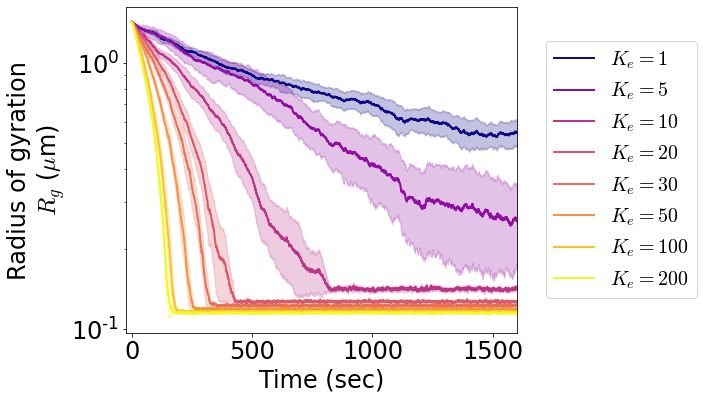

In [14]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

mp = re.compile('Ke(\d*\.?\d+)')

try:
    fig1, axarr1 = plt.subplots(figsize=(7, 6))

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None

    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            rog = aa.calc_rad_of_gyration(com_arr)
            # _ = axarr1.plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$K_e = {label}$")
        ci = (std_ee_list[-1]/np.sqrt(avg_ee_arrs.shape[0])* 1.96) # 95% confidence interval
        _ = axarr1.fill_between(time_arr[:min_length], (avg_ee_list[-1] - ci), (avg_ee_list[-1] + ci),color=colors[i], alpha=.25)
    
    _ = axarr1.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xlim(-25, 1600)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

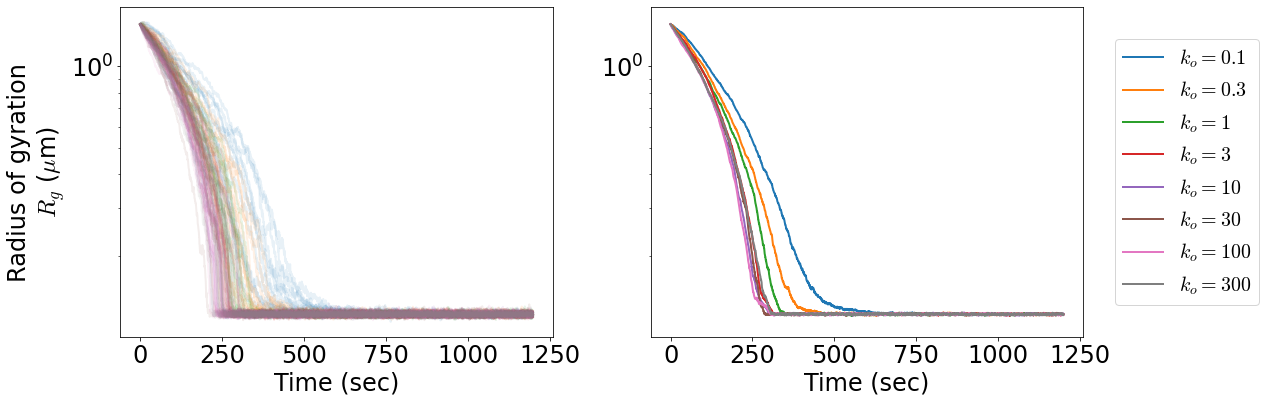

In [ ]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


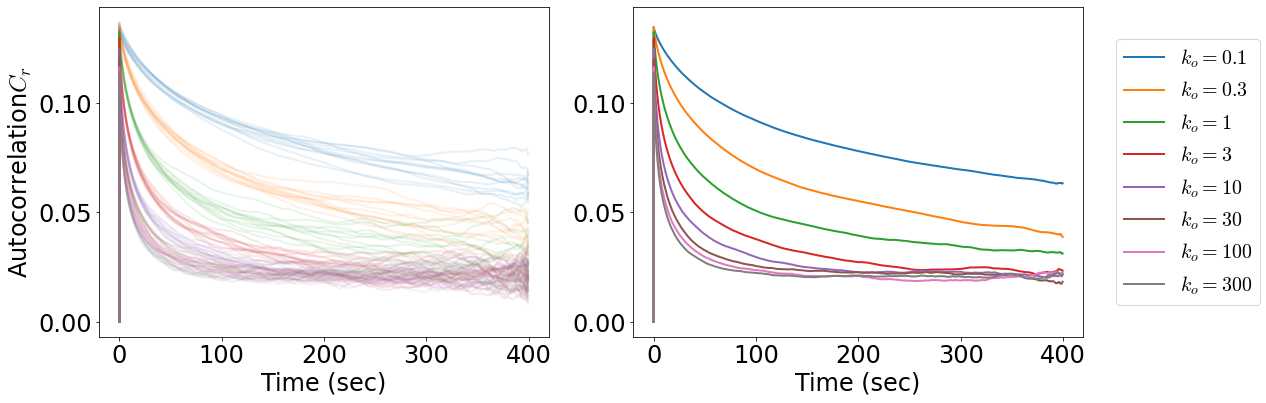

In [7]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


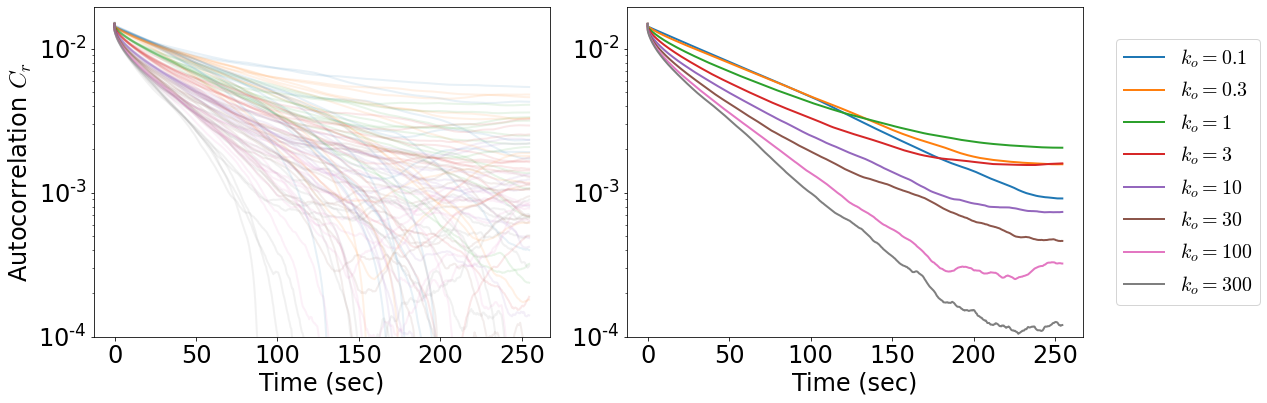

In [11]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0]
[87.10643216870399, 95.70079732015594, 105.34547701211719, 84.80504218465884, 65.39391175795731, 55.18835827875183, 44.430378267001295, 38.87923618649279]
[19.42938584 86.19781378 -0.26392389]


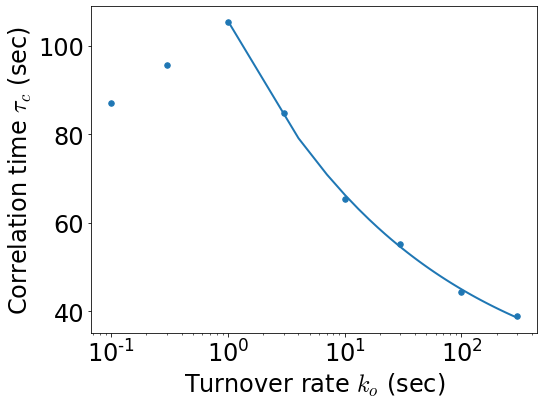

In [51]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    pvals = []
    exp_vals = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        # Find exponential values with a fit
        params, cv = curve_fit(monoExp, lag_arr[:min_length], avg_auto_corr_list[i].to('cpu'))
        exp_vals += [1./params[-1]]
    
    print(pvals)
    print(exp_vals)
    _ = axarr1.scatter(pvals, exp_vals, s=30)
    pow_params, cv = curve_fit(func_powerlaw, pvals[2:], exp_vals[2:], p0=(0, 100, -0.1))
    print(pow_params)
    x = np.linspace(pvals[2], pvals[-1], 100)
    y = func_powerlaw(x, *pow_params)
    _ = axarr1.plot(x, y)

    _ = axarr1.set_ylabel('Correlation time ' + r'$\tau_c$ (sec)')
    _ = axarr1.set_xlabel('Turnover rate $k_o$ (sec)')
    # _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(20, 200)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0]
[87.10643216870399, 95.70079732015594, 105.34547701211719, 84.80504218465884, 65.39391175795731, 55.18835827875183, 44.430378267001295, 38.87923618649279]
[  1.         104.08939903  -0.18448344]


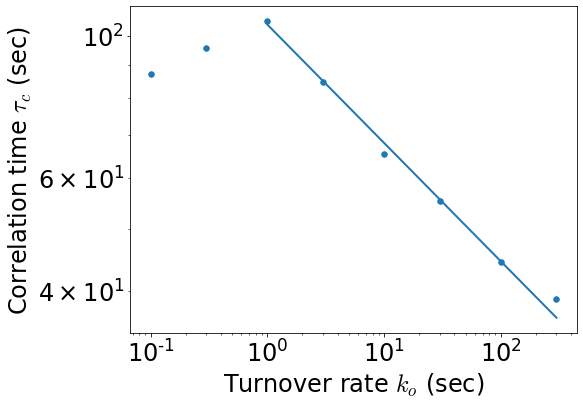

In [54]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    pvals = []
    exp_vals = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        # Find exponential values with a fit
        params, cv = curve_fit(monoExp, lag_arr[:min_length], avg_auto_corr_list[i].to('cpu'))
        exp_vals += [1./params[-1]]
    
    print(pvals)
    print(exp_vals)
    _ = axarr1.scatter(pvals, exp_vals, s=30)
    pow_params, cv = curve_fit(func_powerlaw_zero, pvals[2:], exp_vals[2:])
    print(pow_params)
    x = np.linspace(pvals[2], pvals[-1], 100)
    y = func_powerlaw_zero(x, *pow_params)
    _ = axarr1.plot(x, y)

    _ = axarr1.set_ylabel('Correlation time ' + r'$\tau_c$ (sec)')
    _ = axarr1.set_xlabel('Turnover rate $k_o$ (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(20, 200)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

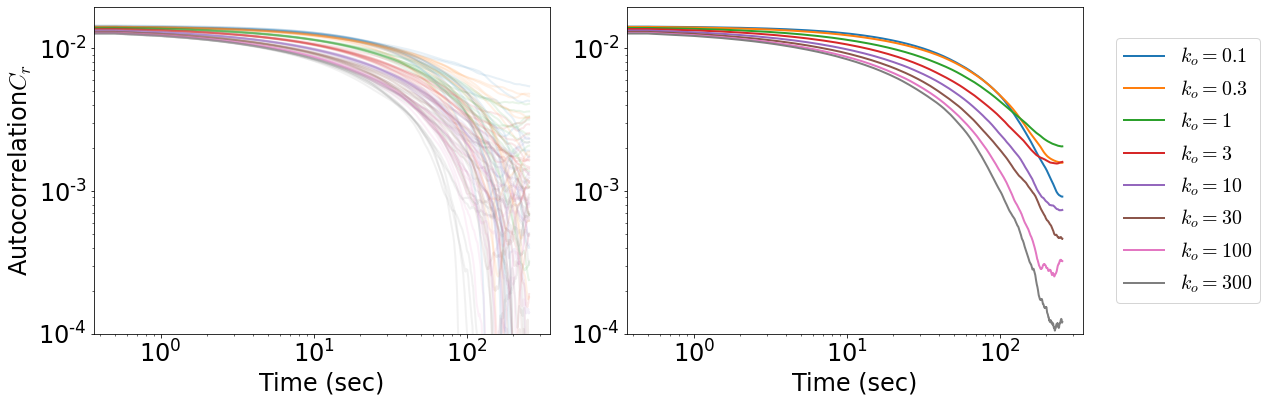

In [18]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

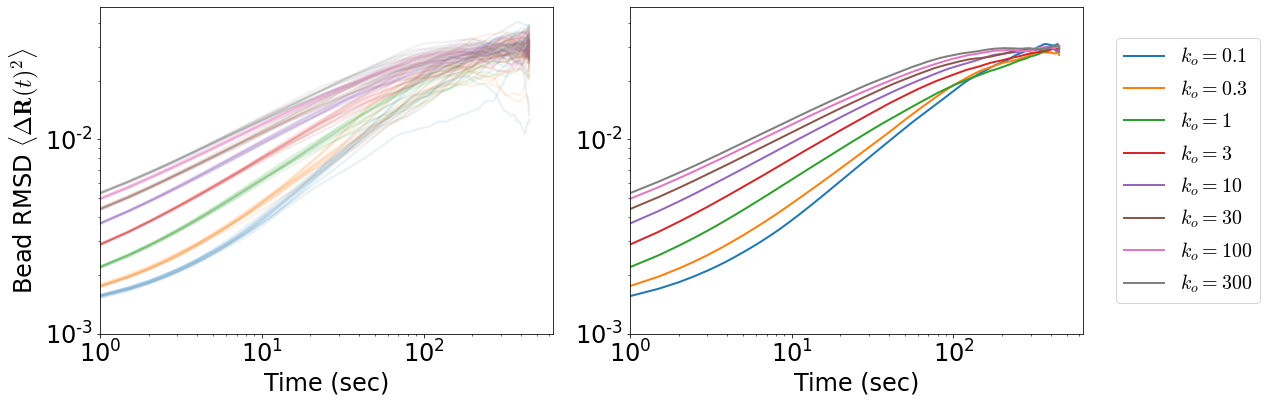

In [21]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Bead RMSD ' + r'$\langle \Delta {\bf R}(t)^2 \rangle$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.001)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## Rheology calculations

0it [00:00, ?it/s]

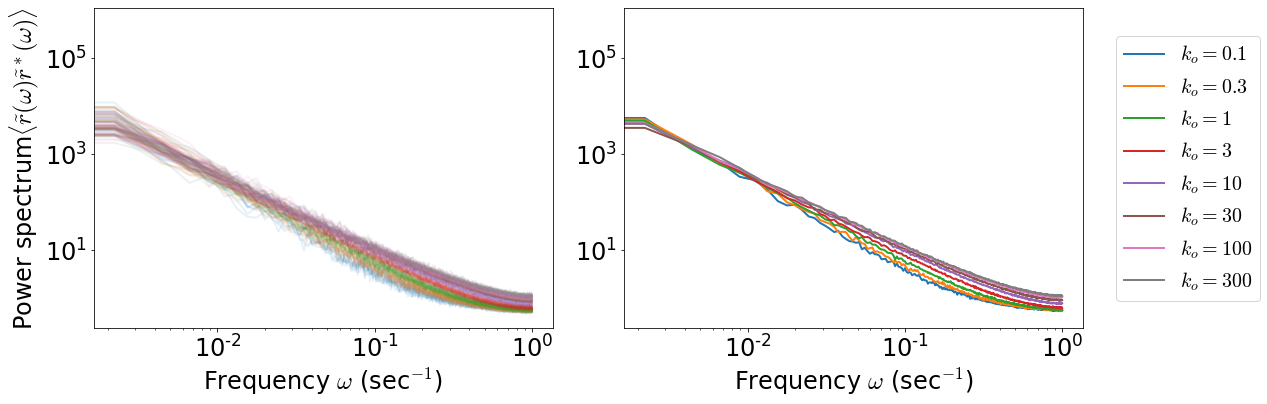

In [67]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_power_spec_list = []
    std_auto_corr_list = []
    fft_avg_rmsd_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in power_spec_list])
        power_spec_mat = torch.stack([avg[:min_length] for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(axis=0)]
        std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_power_spec_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Power spectrum' + r' $\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle$')
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

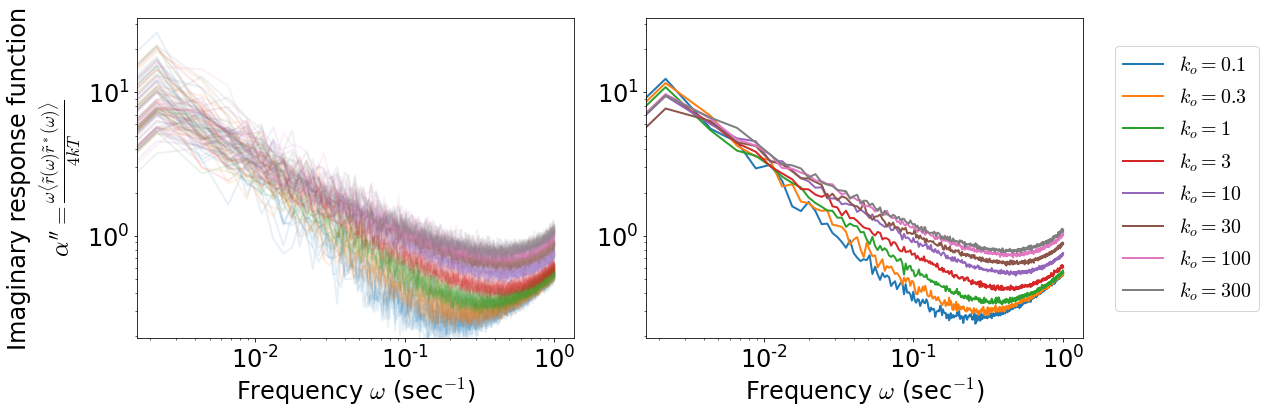

In [65]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_power_spec_list = []
    std_auto_corr_list = []
    fft_avg_rmsd_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            power_spec_list[-1]*=freqs
            _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in power_spec_list])
        power_spec_mat = torch.stack([avg[:min_length] for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(axis=0)]
        std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_power_spec_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Imaginary response function\n' + r"$\alpha'' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{4kT}$")
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

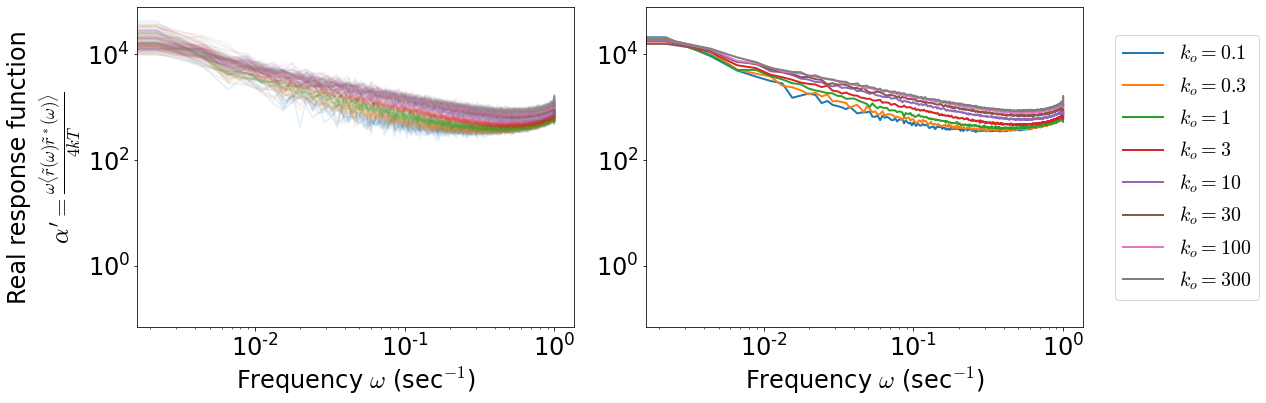

In [ ]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_real_resp_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        im_resp_list = []
        real_resp_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp_list += [freqs * power_spec_list[-1]]
            real_resp_list += [(2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp_list[-1].cpu().numpy())
                )
            )]

            _ = axarr1[0].plot(freqs, real_resp_list[-1], color=colors[i], alpha=.1)
            _ = real_resp_list[-1].to(device)

        min_length = min([len(avg) for avg in real_resp_list])
        real_resp_mat = torch.stack([avg[:min_length] for avg in real_resp_list])
        
        avg_real_resp_list += [real_resp_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_real_resp_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Real response function\n' + r"$\alpha' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{4kT}$")
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

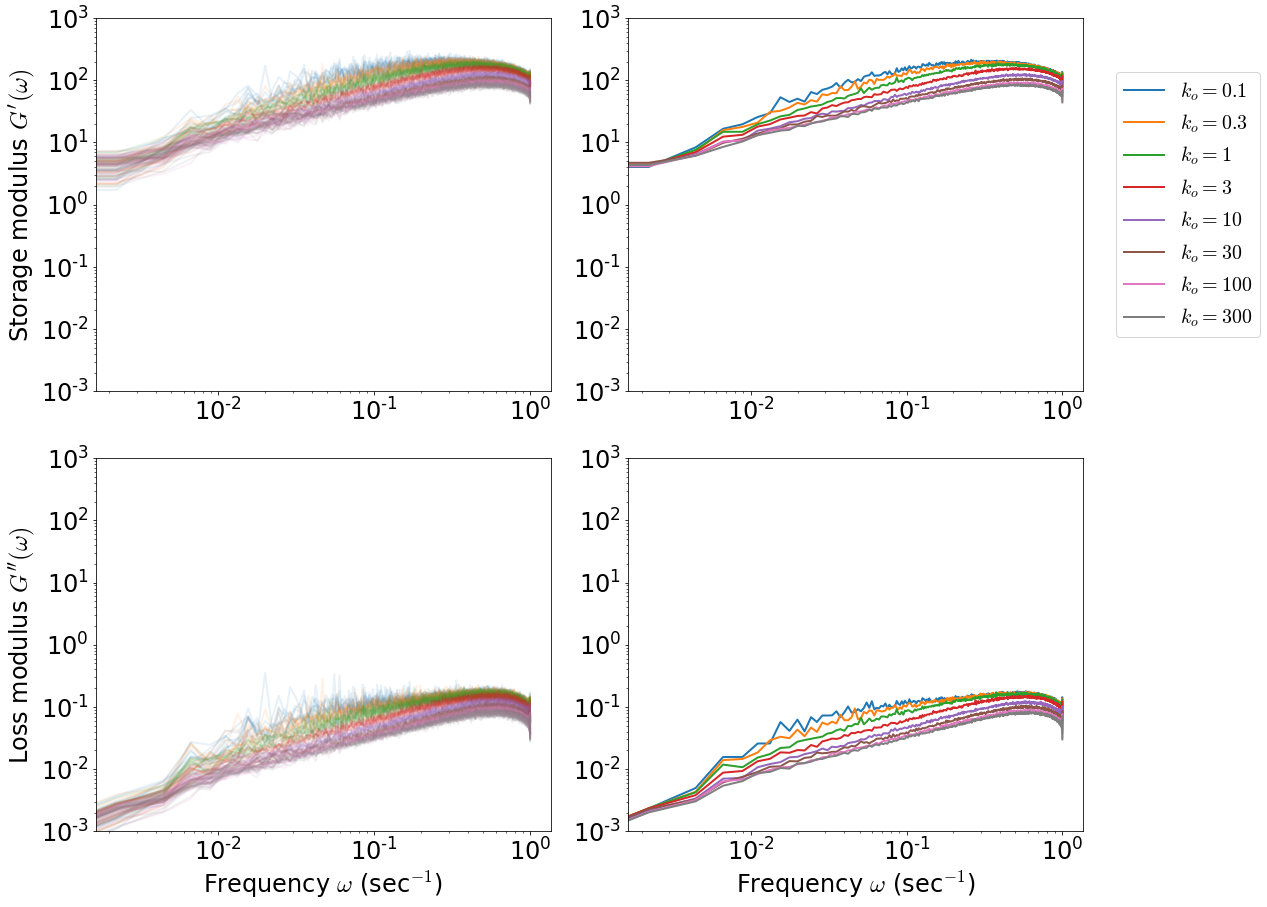

In [75]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
bead_rad = .01
try:
    fig1, axarr1 = plt.subplots(2, 2, figsize=(18, 13))
    axarr1[0,0].sharey(axarr1[0,1])
    axarr1[0,0].sharex(axarr1[0,1])
    axarr1[1,0].sharey(axarr1[1,1])
    axarr1[1,0].sharex(axarr1[1,1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_stor_mod_list = []
    avg_loss_mod_list = []
    pre_fact = 1./(6.*np.pi*bead_rad)
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        stor_mod_list = []
        loss_mod_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1, norm='forward')
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp = freqs * power_spec_list[-1] / (4.* .0041)
            real_resp = (2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp.cpu().numpy())
                )
            ).to(device)
            resp_sqr = im_resp**2 + real_resp**2
            stor_mod_list += [pre_fact*(real_resp/resp_sqr)]
            loss_mod_list += [pre_fact*(im_resp/resp_sqr)]

            _ = axarr1[0,0].plot(freqs, stor_mod_list[-1], color=colors[i], alpha=.1)
            _ = axarr1[1,0].plot(freqs, loss_mod_list[-1], color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in stor_mod_list])
        stor_mat = torch.stack([avg[:min_length] for avg in stor_mod_list])
        loss_mat = torch.stack([avg[:min_length] for avg in loss_mod_list])
        
        avg_stor_mod_list += [stor_mat.mean(axis=0)]
        avg_loss_mod_list += [loss_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[0,1].plot(freqs, (avg_stor_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
        _ = axarr1[1,1].plot(freqs, (avg_loss_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0,0].set_ylabel('Storage modulus ' + r"$G'(\omega)$")
    _ = axarr1[1,0].set_ylabel('Loss modulus ' + r"$G''(\omega)$")
    _ = axarr1[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0,0].set_ylim(.001, 1000)
    _ = axarr1[1,0].set_ylim(.001, 1000)
    _ = axarr1[0,0].set_yscale('log')
    _ = axarr1[0,0].set_xscale('log')
    _ = axarr1[1,0].set_yscale('log')
    _ = axarr1[1,0].set_xscale('log')

    _ = axarr1[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

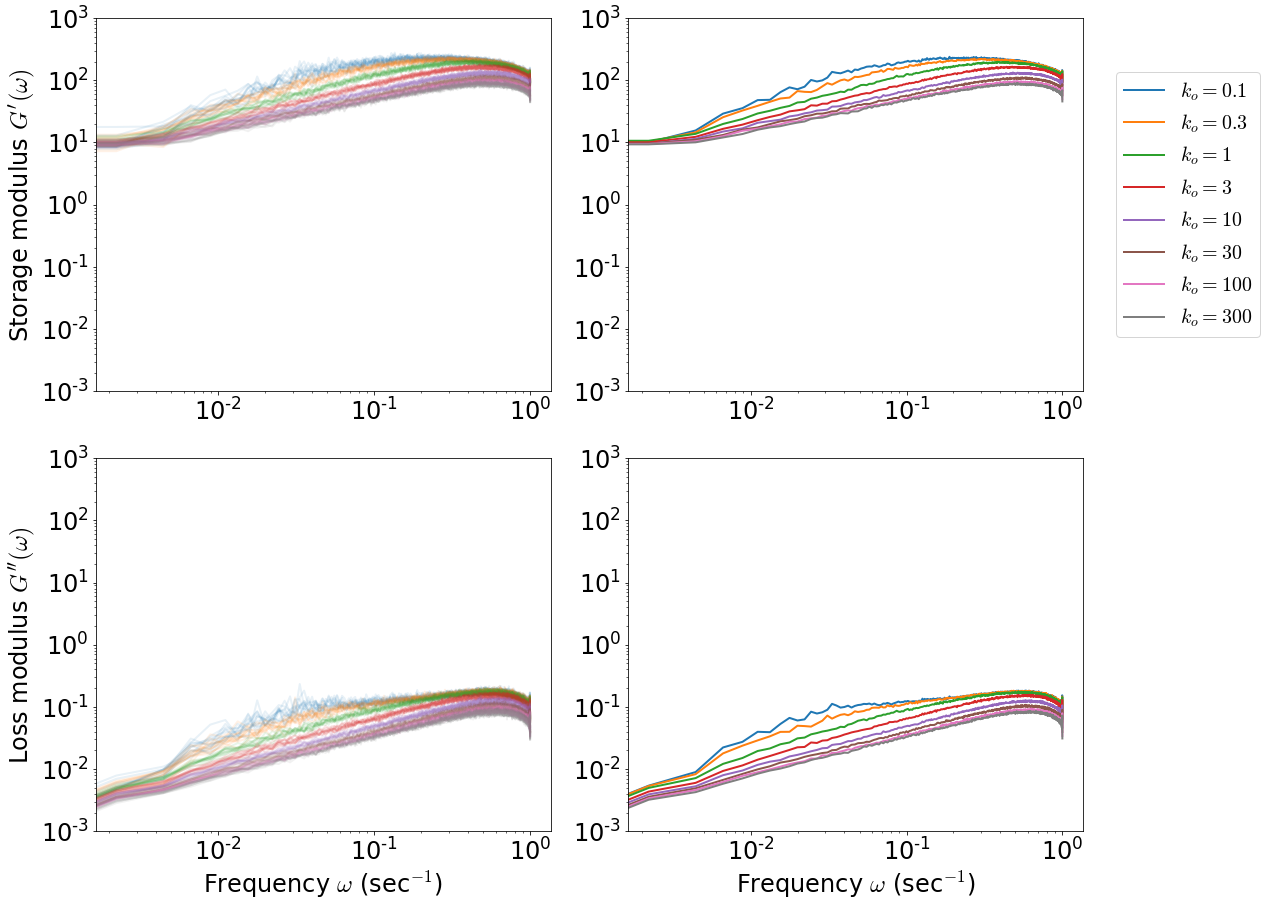

In [78]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
bead_rad = .01
try:
    fig1, axarr1 = plt.subplots(2, 2, figsize=(18, 13))
    axarr1[0,0].sharey(axarr1[0,1])
    axarr1[0,0].sharex(axarr1[0,1])
    axarr1[1,0].sharey(axarr1[1,1])
    axarr1[1,0].sharex(axarr1[1,1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_stor_mod_list = []
    avg_loss_mod_list = []
    pre_fact = 1./(6.*np.pi*bead_rad)
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        stor_mod_list = []
        loss_mod_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            com_arr -= com_arr.mean(axis=0) 
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1, norm='forward')
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp = freqs * power_spec_list[-1] / (4.* .0041)
            real_resp = (2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp.cpu().numpy())
                )
            ).to(device)
            resp_sqr = im_resp**2 + real_resp**2
            stor_mod_list += [pre_fact*(real_resp/resp_sqr)]
            loss_mod_list += [pre_fact*(im_resp/resp_sqr)]

            _ = axarr1[0,0].plot(freqs, stor_mod_list[-1], color=colors[i], alpha=.1)
            _ = axarr1[1,0].plot(freqs, loss_mod_list[-1], color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in stor_mod_list])
        stor_mat = torch.stack([avg[:min_length] for avg in stor_mod_list])
        loss_mat = torch.stack([avg[:min_length] for avg in loss_mod_list])
        
        avg_stor_mod_list += [stor_mat.mean(axis=0)]
        avg_loss_mod_list += [loss_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[0,1].plot(freqs, (avg_stor_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
        _ = axarr1[1,1].plot(freqs, (avg_loss_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0,0].set_ylabel('Storage modulus ' + r"$G'(\omega)$")
    _ = axarr1[1,0].set_ylabel('Loss modulus ' + r"$G''(\omega)$")
    _ = axarr1[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0,0].set_ylim(.001, 1000)
    _ = axarr1[1,0].set_ylim(.001, 1000)
    _ = axarr1[0,0].set_yscale('log')
    _ = axarr1[0,0].set_xscale('log')
    _ = axarr1[1,0].set_yscale('log')
    _ = axarr1[1,0].set_xscale('log')

    _ = axarr1[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## $\ell_s$ scans

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


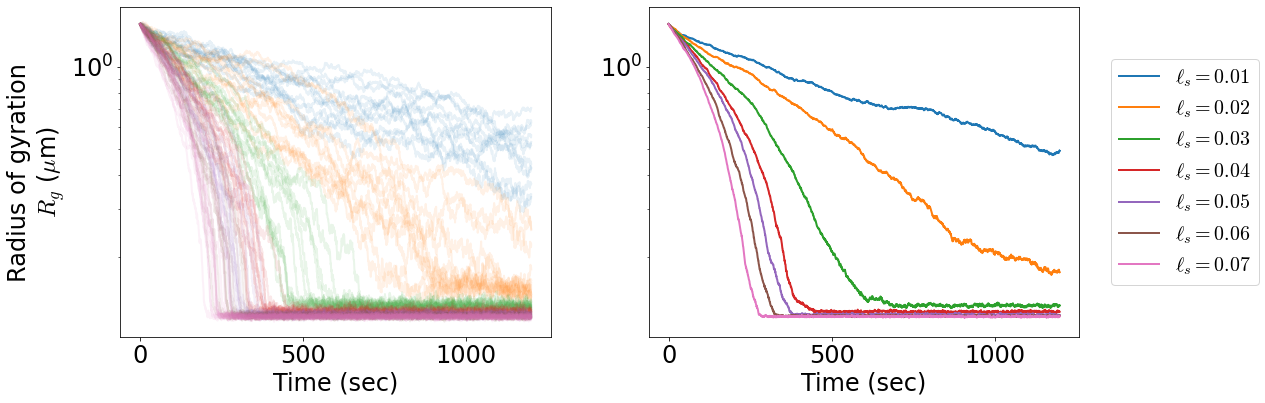

In [7]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$\ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

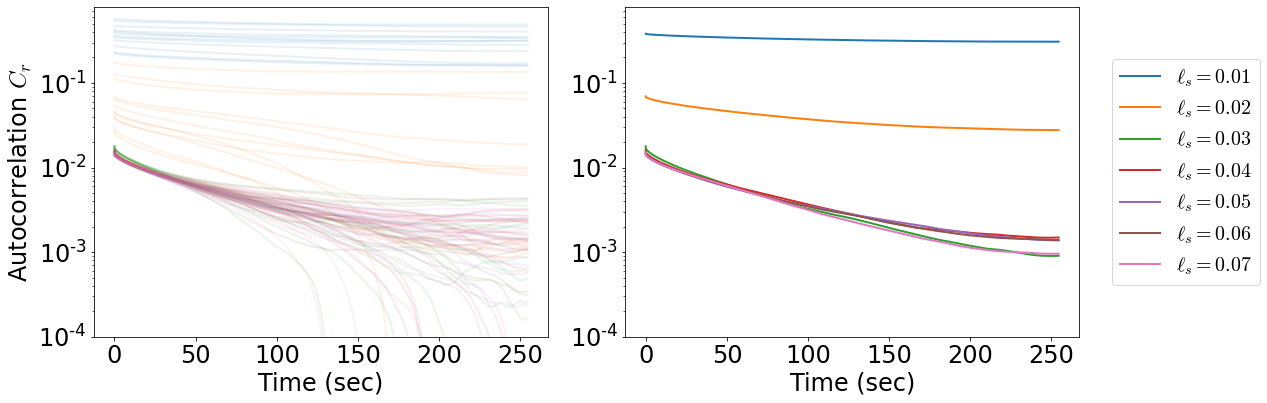

In [57]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$\ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

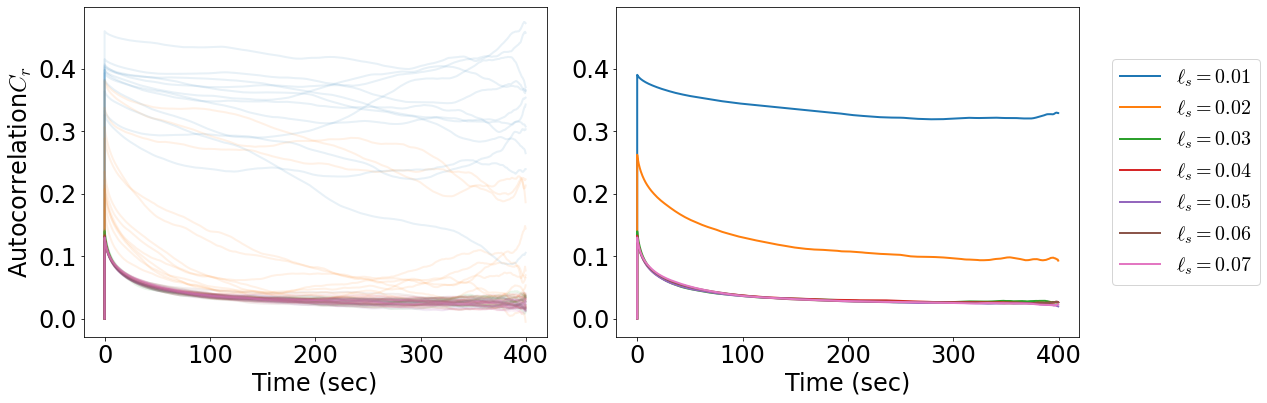

In [10]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ \ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r'$ C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

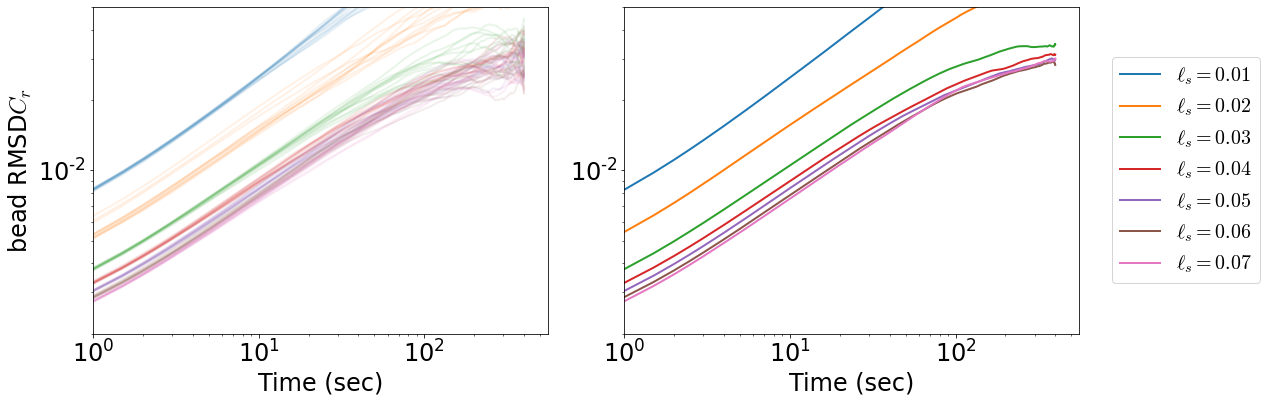

In [9]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ \ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('bead RMSD' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.002, .05)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## Bead number scans

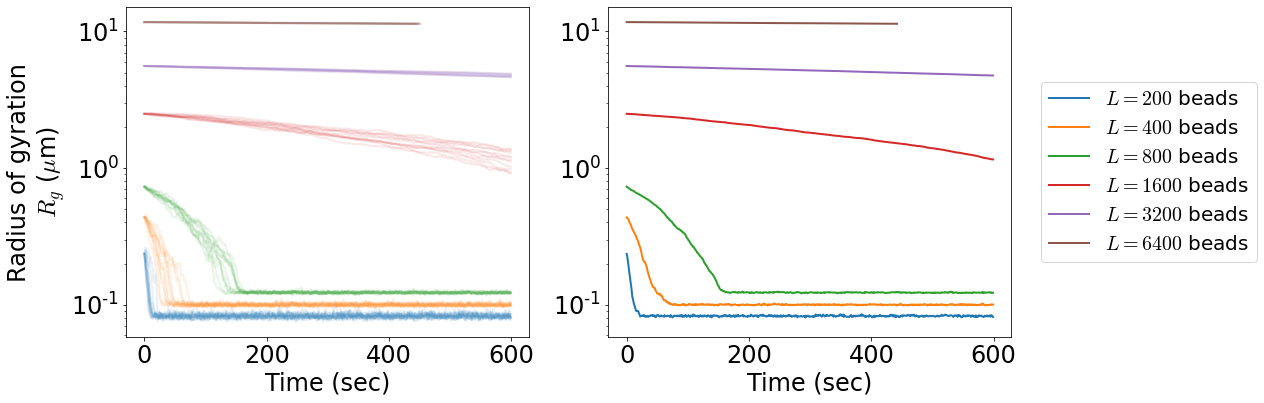

In [11]:
data_path = ceph_path / "CondCharPaper/22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations/"
colors = list(mcolors.TABLEAU_COLORS.keys())
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('line(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None


    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('simulations/s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$L = {label}$ beads")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

# Cluster size

One way edge found for cond 5
One way edge found for cond 2
One way edge found for cond 11


(0.0, 5.587906563282013)

(0.0, 342.2)

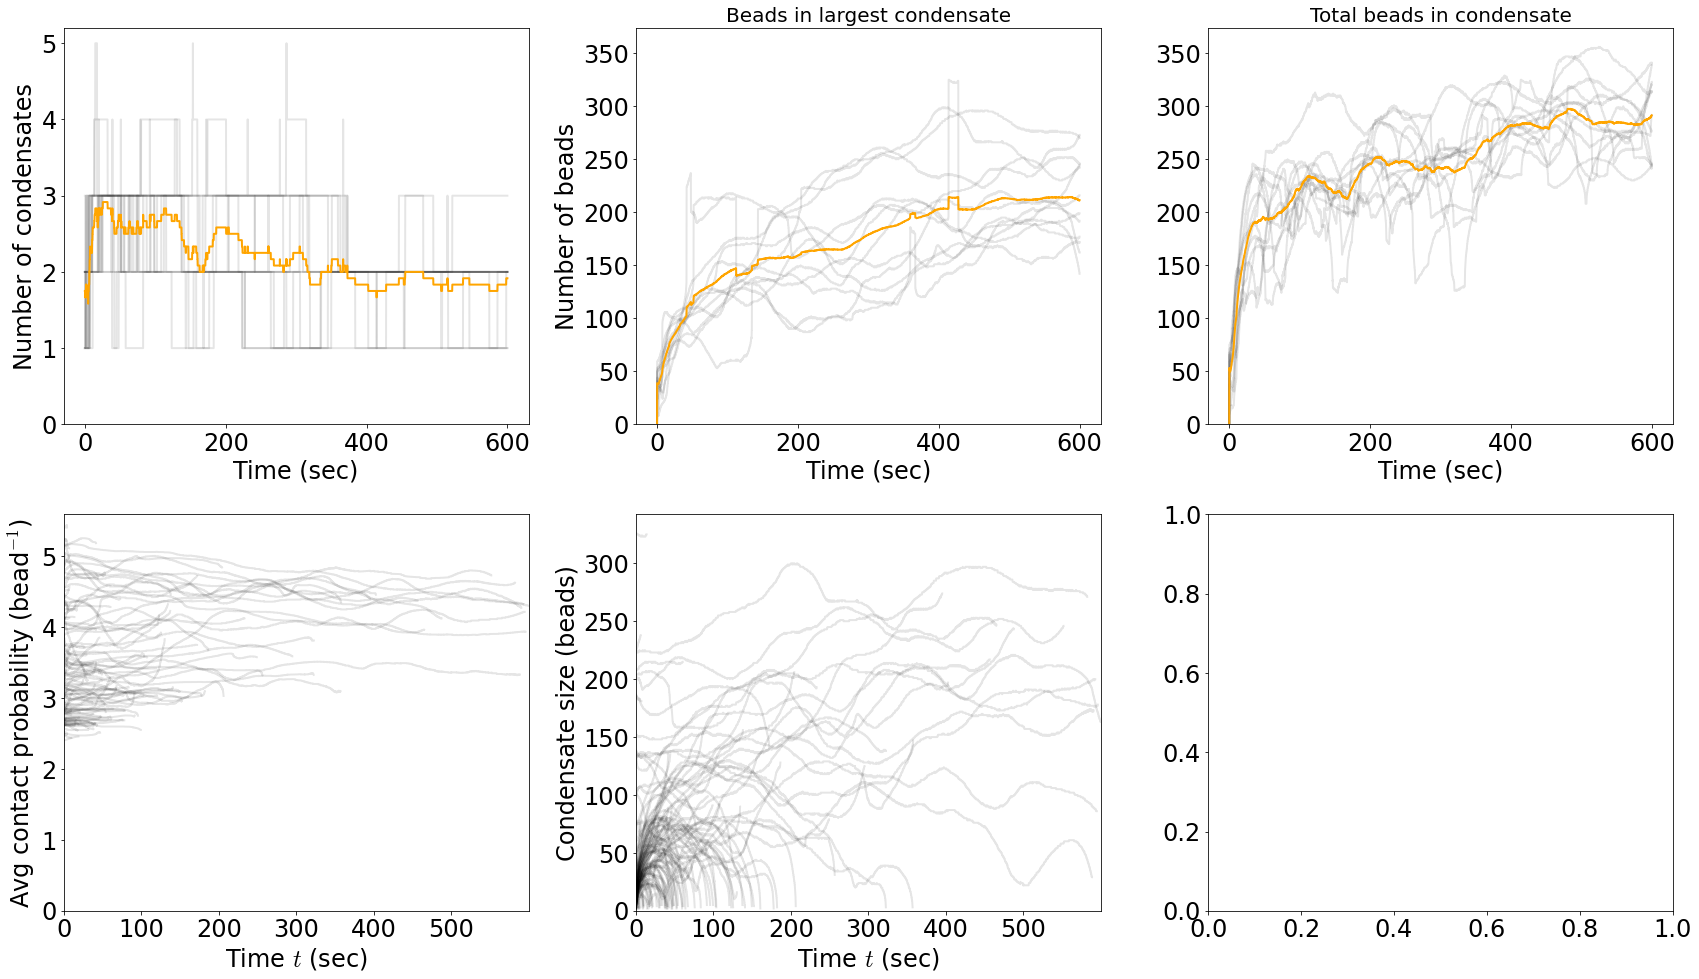

In [5]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]
        contact_cond_num = analysis_grp['contact_cond_num'][...]

        stored_condensates = aa.gen_condensate_track_info(time_arr, contact_cond_edges, contact_cond_num) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

Super merging event occured at cond 5
One way edge found for cond 13


(0.0, 5.431228077411651)

(0.0, 319.1)

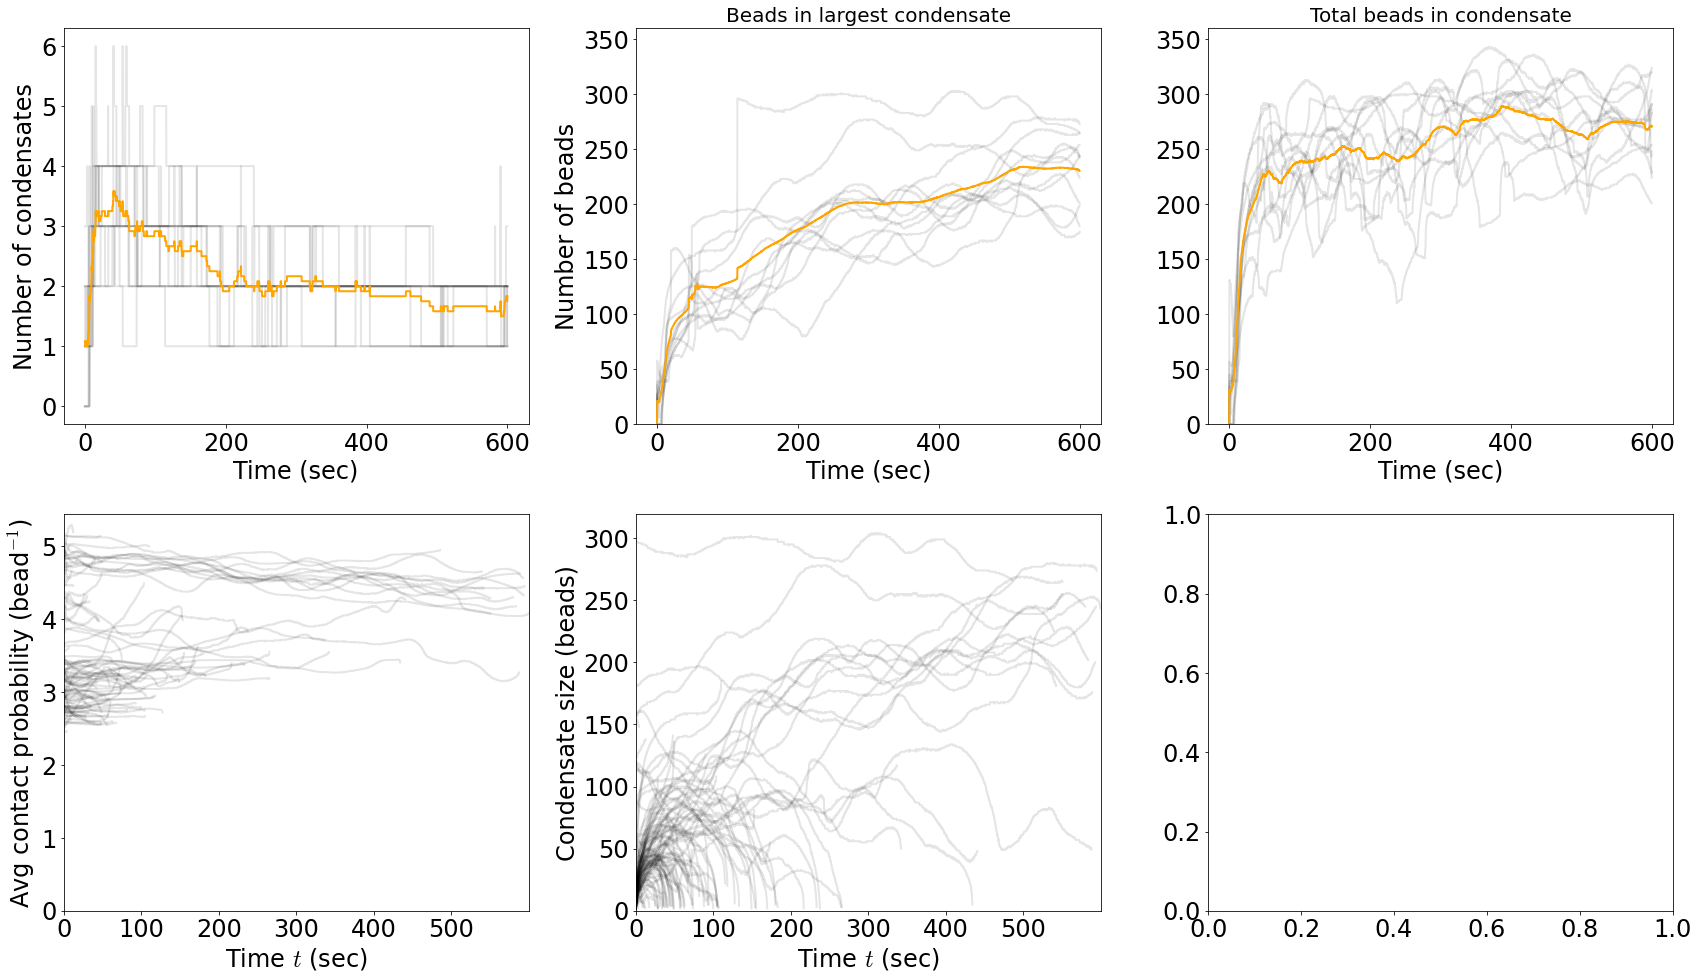

In [126]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_rigid20_conf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]

        stored_condensates = aa.gen_condensate_track_info(h5_data) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

/mnt/home/alamson/projects/analysis/AMSOS_Analysis/alens_analysis/chrom_seed_scan_analysis.py:95: RuntimeWarning: divide by zero encountered in log
  return log_avg_contact_mat


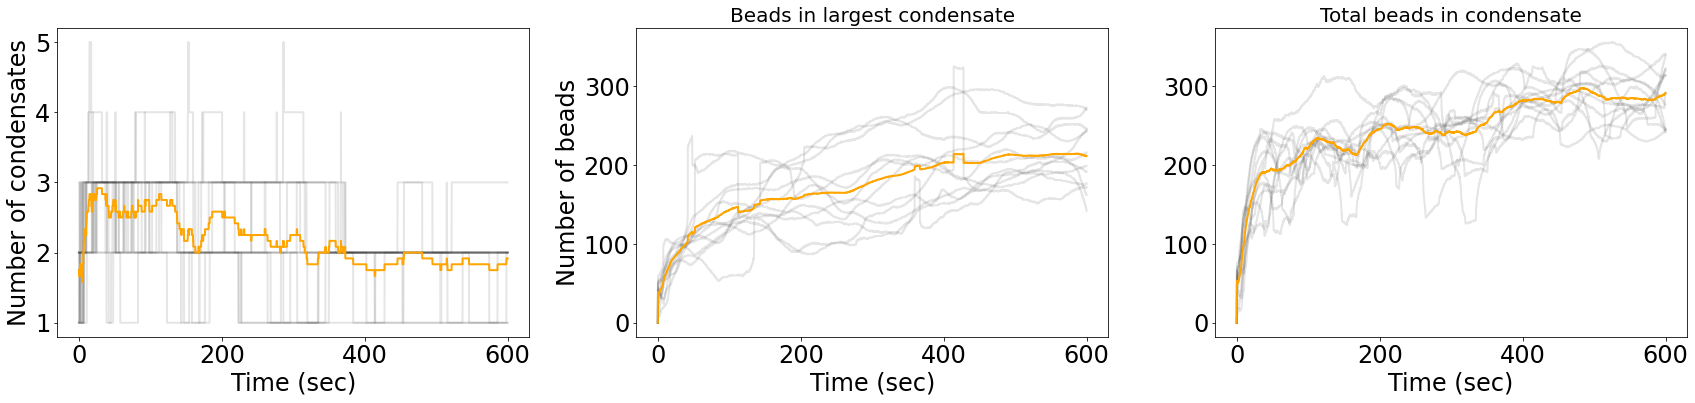

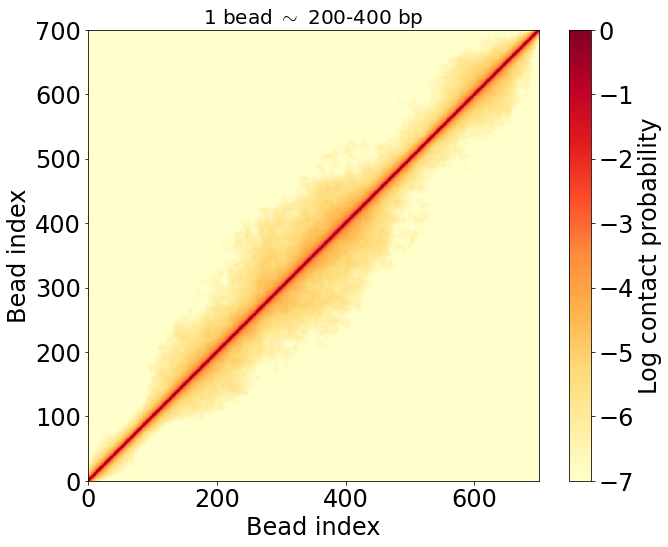

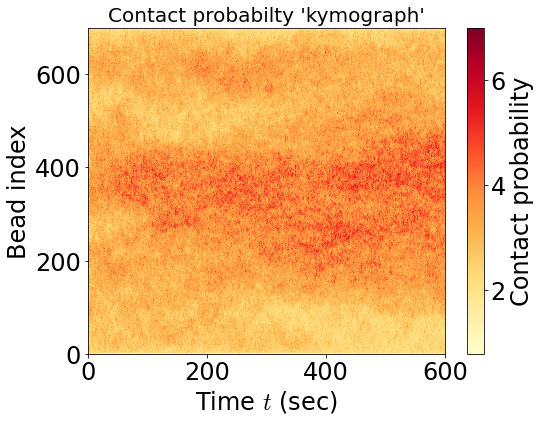

In [80]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"

try:
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]

    fig1, axarr1 = plt.subplots(1, 3, figsize=(24, 6))
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(sd_h5_data_lst)
    
    aa.plot_condensate_num_sd_scan(axarr1[0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(axarr1[1:], time_arr, max_width_arr, total_bead_arr)
    fig1.tight_layout()
    
    log_avg_contact_mat = aa.get_scan_avg_contact_mat(sd_h5_data_lst)
    fig2, ax2 = aa.make_hic_plot(nbeads, log_avg_contact_mat, vmin=-7.)
    
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    avg_contact_kymo = aa.get_scan_avg_kymo(sd_h5_data_lst)
    aa.plot_contact_kymo(fig3, ax3, time_arr, avg_contact_kymo, vmax=7.)
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

## Average run tests

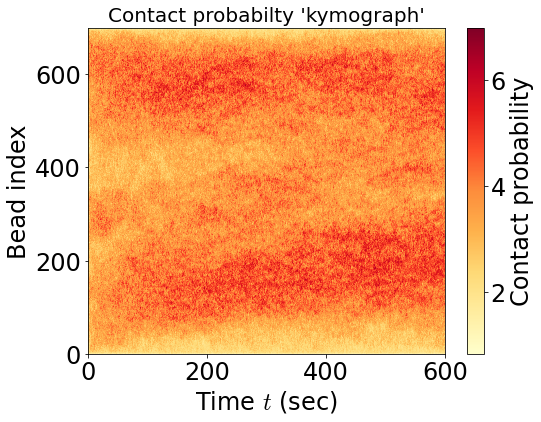

In [10]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/"
ss_ind = 0
fig, ax = plt.subplots(figsize=(8,6))
avg_contact_kymo = None
num_seeds = 0.
h5_data_lst = []

try:
    for h5_path in data_path.glob('s*/analysis/*.h5'):
        h5_data_lst += [h5py.File(h5_path, 'r+')]
    for h5d in h5_data_lst:
        if avg_contact_kymo is None:
            time_arr = h5d['time'][1:-1]
            avg_contact_kymo = h5d['analysis']['contact_kymo'][...]
        else:
            avg_contact_kymo += h5d['analysis']['contact_kymo'][...]
        num_seeds += 1.
        
    aa.plot_contact_kymo(fig, ax, time_arr, avg_contact_kymo/num_seeds, vmax=7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

# Conclusions and Next Steps